In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr

observations = pd.read_csv("observations.csv")
species = pd.read_csv("species_info.csv")

print(observations.groupby("park_name").size())
print('\n')

observations.head()

park_name
Bryce National Park                    5824
Great Smoky Mountains National Park    5824
Yellowstone National Park              5824
Yosemite National Park                 5824
dtype: int64




,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [152]:
print(species.groupby("category").size())
print('\n')
print(species.groupby("conservation_status").size())
species.head()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64


conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [147]:
observations_totals = observations.groupby(['scientific_name', 'park_name'])['observations'].sum().reset_index()
observations_totals.head()

,scientific_name,park_name,observations
0,Abies bifolia,Bryce National Park,109
1,Abies bifolia,Great Smoky Mountains National Park,72
2,Abies bifolia,Yellowstone National Park,215
3,Abies bifolia,Yosemite National Park,136
4,Abies concolor,Bryce National Park,83


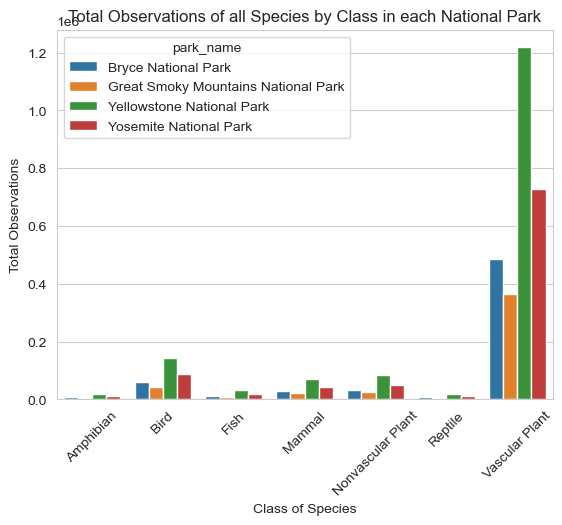

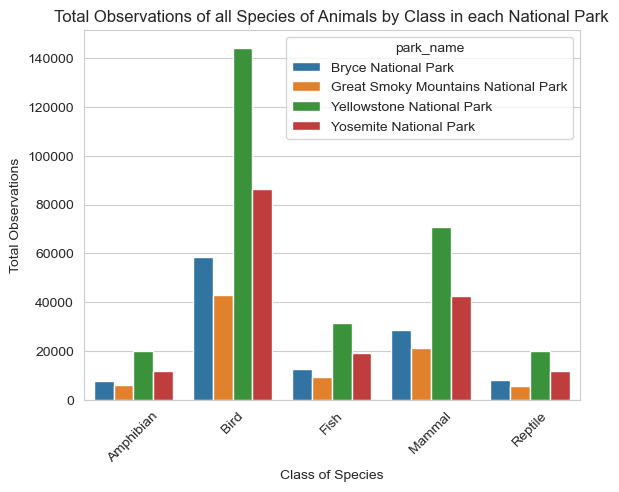

<Figure size 640x480 with 0 Axes>

In [161]:
merged = pd.merge(observations_totals, species, on='scientific_name')

merged_category_park = merged.groupby(['category', 'park_name'])['observations'].sum().reset_index()

sns.barplot(x='category', y='observations', hue='park_name', data=merged_category_park)
plt.title('Total Observations of all Species by Class in each National Park')
plt.ylabel('Total Observations')
plt.xlabel('Class of Species')
plt.xticks(rotation=45)
plt.show()
plt.clf()

only_animals = merged[~merged['category'].isin(['Nonvascular Plant', 'Vascular Plant'])]
only_animals_totals = only_animals.groupby(['category', 'park_name'])['observations'].sum().reset_index()

sns.barplot(x='category', y='observations', hue='park_name', data=only_animals_totals)
plt.title('Total Observations of all Species of Animals by Class in each National Park')
plt.ylabel('Total Observations')
plt.xlabel('Class of Species')
plt.xticks(rotation=45)
plt.show()
plt.clf()

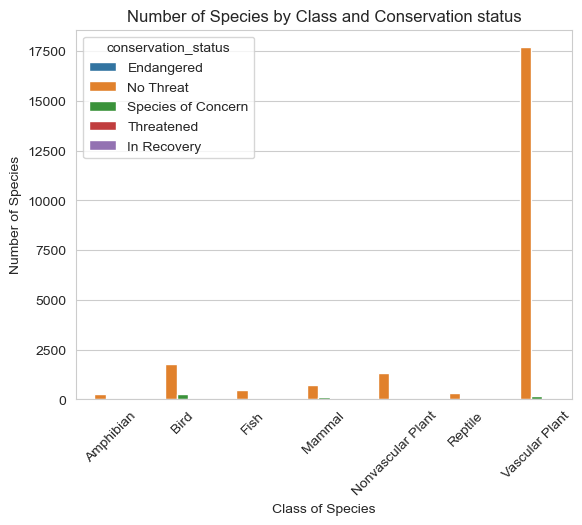

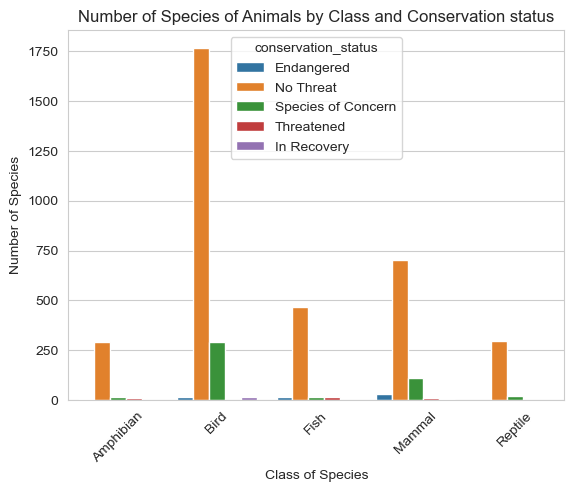

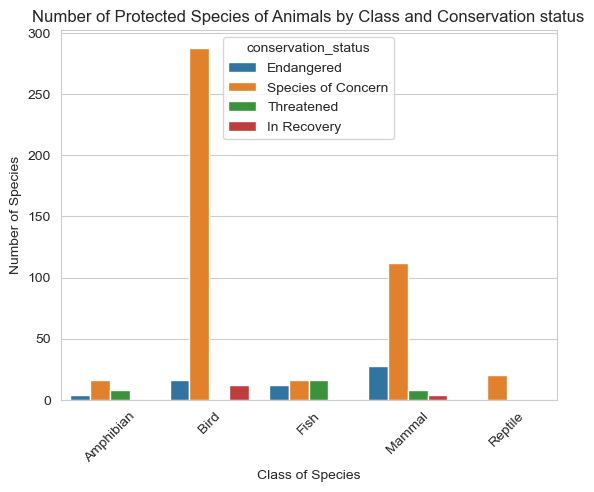

<Figure size 640x480 with 0 Axes>

In [162]:
merged['conservation_status'] = merged['conservation_status'].fillna('No Threat')
merged_counts = merged.groupby(['category', 'conservation_status'])['scientific_name'].count().reset_index()

sns.barplot(x='category', y='scientific_name', hue='conservation_status', data=merged_counts)
plt.xticks(rotation=45)
plt.title('Number of Species by Class and Conservation status')
plt.ylabel('Number of Species')
plt.xlabel('Class of Species')
plt.show()
plt.clf()

filtered = merged[~merged['category'].isin(['Nonvascular Plant', 'Vascular Plant'])]
filtered_totals = filtered.groupby(['category', 'conservation_status'])['scientific_name'].count().reset_index()

sns.barplot(x='category', y='scientific_name', hue='conservation_status', data=filtered_totals)
plt.title('Number of Species of Animals by Class and Conservation status')
plt.ylabel('Number of Species')
plt.xlabel('Class of Species')
plt.xticks(rotation=45)
plt.show()
plt.clf()


endangered = filtered_totals[~filtered_totals['conservation_status'].isin(['No Threat'])]

sns.barplot(x='category', y='scientific_name', hue='conservation_status', data=endangered)
plt.title('Number of Protected Species of Animals by Class and Conservation status')
plt.ylabel('Number of Species')
plt.xlabel('Class of Species')
plt.xticks(rotation=45)
plt.show()
plt.clf()



In [174]:
species.fillna('No Intervention', inplace=True)
print(species.groupby("conservation_status").size())

species['is_protected'] = species.conservation_status != 'No Intervention'

protected_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index()

protected_counts = protected_counts.pivot(columns='is_protected', index='category', values='scientific_name').reset_index()

protected_counts.columns = ['category', 'not_protected', 'protected']

protected_counts['percent_protected'] = protected_counts.protected / \
                                      (protected_counts.protected + protected_counts.not_protected) * 100


protected_counts

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64


,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


In [177]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(protected_counts['category'], 
                                [protected_counts['protected'], protected_counts['not_protected']])

# perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-square test results:")
print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"p-value: {p_val:.4f}")

Chi-square test results:
Chi-square statistic: 42.00
p-value: 0.2270


In [139]:
max_obs = merged.groupby(['category'])['observations'].idxmax()
max_obs_df = merged.loc[max_obs]

max_obs_df

,scientific_name,park_name,observations,category,common_names,conservation_status
17832,Rana catesbeiana,Yellowstone National Park,497,Amphibian,American Bullfrog,No Threat
20970,Streptopelia decaocto,Yellowstone National Park,771,Bird,Eurasian Collared-Dove,No Threat
18984,Salvelinus fontinalis,Yellowstone National Park,513,Fish,Brook Trout,No Threat
17578,Puma concolor,Yellowstone National Park,753,Mammal,Panther (Mountain Lion),No Threat
16534,Pogonatum brachyphyllum,Yellowstone National Park,307,Nonvascular Plant,Pogonatum Moss,No Threat
4996,Charina bottae,Yellowstone National Park,507,Reptile,Rubber Boa,No Threat
10270,Holcus lanatus,Yellowstone National Park,805,Vascular Plant,"Common Velvet Grass, Velvetgrass",No Threat


In [140]:
max_obs_park = merged.groupby(['park_name', 'category'])['observations'].idxmax()
max_obs_park_df = merged.loc[max_obs_park]

max_obs_park_df

,scientific_name,park_name,observations,category,common_names,conservation_status
17828,Rana catesbeiana,Bryce National Park,162,Amphibian,American Bullfrog,No Threat
5660,Columba livia,Bryce National Park,339,Bird,Rock Dove,No Threat
18980,Salvelinus fontinalis,Bryce National Park,236,Fish,Brook Trout,No Threat
17572,Puma concolor,Bryce National Park,311,Mammal,Panther (Mountain Lion),No Threat
2600,Brachythecium rutabulum,Bryce National Park,156,Nonvascular Plant,Brachythecium Moss,No Threat
4992,Charina bottae,Bryce National Park,191,Reptile,Rubber Boa,No Threat
2208,Avena sativa,Bryce National Park,303,Vascular Plant,"Cultivated Oat, Oats",No Threat
17830,Rana catesbeiana,Great Smoky Mountains National Park,169,Amphibian,American Bullfrog,No Threat
20967,Streptopelia decaocto,Great Smoky Mountains National Park,256,Bird,Eurasian Collared-Dove,No Threat
18982,Salvelinus fontinalis,Great Smoky Mountains National Park,176,Fish,Brook Trout,No Threat
